# CS 109A/AC 209A/STAT 121A Data Science: Homework 6
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW6.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
#from sklearn import discriminant_analysis   # don't work
from sklearn.lda import LDA  #sklearn = 0.15.2 ??
from sklearn.qda import QDA  #sklearn = 0.15.2 ??
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split as sk_split
import sklearn.neighbors as knn
import collections
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Galvin, Owen

### Part (b): Course Number

CS 109a Extension

### Part (c): Who did you work with?

None

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

In [2]:
# load first dataset
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22,377,0
1,62,257,0
2,95,546,0
3,38,95,1
4,63,277,1


In [3]:
# load second dataset
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


In [4]:
# lab 7 code

#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

In [5]:
# lab 7 code, use total percentage of likes to rank the movies, as a metric for likability

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]


#Print results of ranking
title_padding = max(len(movie[0]) for movie in top_25_movies) + 5
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print '{0:<{1}} {2:<10} ({3}/{4})'.format(movie, title_padding, likable, likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995)                              1.0        (2.0/2.0)
Exotica (1994)                                                  1.0        (2.0/2.0)
Three Colors: Red (1994)                                        1.0        (12.0/12.0)
Three Colors: White (1994)                                      1.0        (8.0/8.0)
Shawshank Redemption, The (1994)                                1.0        (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994)         1.0        (1.0/1.0)
Carlito's Way (1993)                                            1.0        (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994)                  1.0        (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)      1.0        (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996)          1.0        (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994)                          1.0        (1.0/1.0)
Unhook the Stars (

#### Task: 
- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

Total number of likes doesn't take non-likes into consideration - there could be a movie with a limited release that is only seen by relatively few people, e.g. 100,000, but almost all of them liked it, so we might end up wit 90,000 likes. On the other hand there could be a heavily marketed movie that is seen by tens of millions of people and even though only 10% of them liked the movie, the total number of likes could still be a few million, far higher than the 90,000 likes in the previous example.  
Using a percentage of likes is a more accurate predictor of how a given user will like a movie. Because the percentage of likes maximizes the likelihood that a movie will indeed be liked, it serves as a proxy for the probability that a (future) user will like the movie.  
A potential drawback has to do with the number of people who have actually conducted ratings on a given movie - a like percentage can overfit the data in that scenario. Taken to an extreme, if 9 out of 10 people liked a movie and there were only 10 that saw the movie, this will potentially fail to generalize to a larger population. Looking at the number of ratings in the "top 25" result, we see many that have only one or two ratings, which would not serve as an effective prediction for the populace at larege. 

A more real-world example with movies would deal with self-selection, where some of the most highly ranked movies in Netflix tend to be special-interest documentaries - one tends to think if a larger, more random selection of Netflix viewers were to watch these documentaries the overall rating would likely decrease significantly.


---

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

In [6]:
# PRE-FILLED: plot_beta_prior 

#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    rv = sp.stats.beta(a, b)
    x = np.linspace(0, 1, 100)
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    return ax

In [7]:
# PRE-FILLED: sample_posterior 

#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [8]:
# Lab 7 code

#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

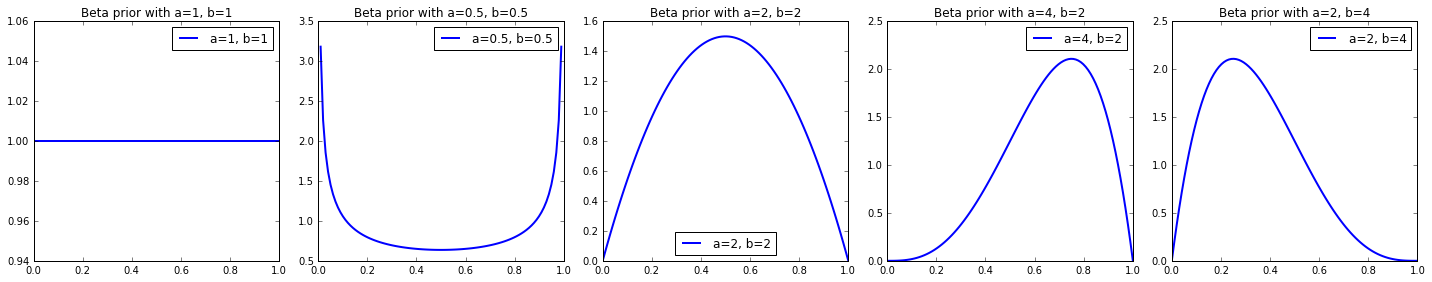

In [9]:
#Lab 7 code, explore the shapes of various beta pdfs

#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0
#Iterate through all the shapes
for a, b in beta_shapes:
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 


#### Task: - **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?

Adding prior beliefs will help overcome overfitting, one of the main concerns we ran into with the probability rating. In this manner we certainly base the likability on the data, but also contribute domain knowledge about what seems common sense when it comes to predicting likability of movies.  

Beta distributions are appropriate for this example since what we are doing is predicting probability. Beta distributions range from 0 to 1, just like probability, and for this reason are often used as priors when the end goal is a probability.

Looking at the beta distributions above, each one expresses a different belief as to how we expect (via our prior domain and/or common-sense knowledge) a given movie's likability to work:
- beta distribution of a=1, b=1
  - Here we are actually saying that we don't have any prior knowledge
- a=0.5, b=0.5
  - Our belief is that most people either love or hate the movie, with a relatively small proportion of people giving it middling reviews
- a=2, b=2
  - We think 50/50 chance people will like the movie
- a=4, b=2
  - With a mode around 0.75, our belief is that most people will like the movie
- a=2, b=4
  - With a mode around 0.25, our belief is that most people will NOT like the movie


#### Task: 
- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.

In [10]:
# Lab 7 code, turned into function

def plot_movie_posterior(movie_name, likability, likes, total_ratings, n_samples):
    #Print movie info
    print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

    #Number of samples to use when approximating our posterior
    #n_samples = 10000

    #Plot the posterior corresponding to each prior
    fig, ax = plt.subplots(1, n, figsize=(20, 4))

    #Start the index of the current subplot at 0
    ax_ind = 0
    #Map the plot index to summary description
    ax_map = ('no prior belief','polarizing','middling','likely good','likely bad')

    #Iterate through all the shapes
    for a, b in beta_shapes:   
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
        #Approximate the posterior with a histogram of these samples
        ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        #Plot the mode as a vertical line
        ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')

        #Set title, legends etc
        top_title = 'Plot {} ({})'.format(ax_ind + 1, ax_map[ax_ind]) 
        ax[ax_ind].set_title('{}\nPosterior, with Beta prior (a={}, b={})'.format(top_title, a, b))
        ax[ax_ind].legend(loc='best')
        #Best case would be to set the xlim as per below and make all the charts bigger, but demand
        # on real estate is simply too much, so even though below helps with common-sense interpretability
        # it hurts the ability to actually see the data, is too squished in a 5-column chart layout
        #ax[ax_ind].set_xlim([0, 1])
        #Increment the subplot index
        ax_ind += 1

    plt.tight_layout()
    plt.show() 

In [12]:
# turn top_25_movies list of tuples into a dataframe
df_movies = pd.DataFrame(sorted_likability, columns=['movie', 'likes', 'total_ratings', 'likability'])

# define function to pull out info from the df_movies created above, by matching on first n characters of title
def plot_movie_posterior_from_title(title, n_samples=10000):
    movie = df_movies[df_movies['movie'].apply(lambda movie: movie[:len(title)]) == title]
    movie_name, likes, total_ratings,likability = movie.values[0]
    plot_movie_posterior(movie_name, likability, likes, total_ratings, n_samples)


Toy Story (1995): 0.745098039216 (38.0/51.0)


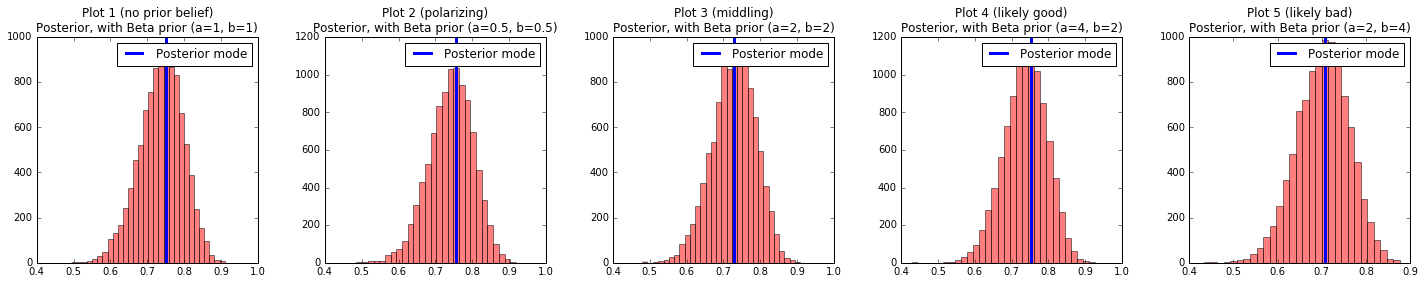

In [13]:
title = 'Toy Story'
#title = 'French Twist'
plot_movie_posterior_from_title(title)

Analysis, Toy Story: 
- various beta distributions, as priors, have relatively small effect on posterior distribution of the 'likability'
- in each case the probability is about 0.75, in 4 we see it is a little higher and in 5 it is lower, closer to 0.70 - this last one probably shows the greatest effect
- also, in 2 & 5 the data is less peaky, with longer tails to show we are less sure about the probabilities

Star Wars (1977): 0.865671641791 (58.0/67.0)


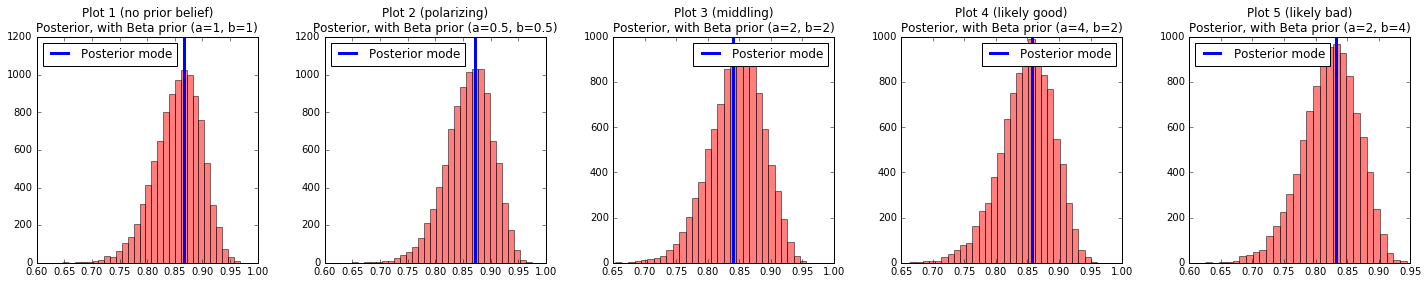

In [14]:
title = 'Star Wars'
plot_movie_posterior_from_title(title)

Analysis, Star Wars:
- similar overall to Toy Story, above, with each distribution not having too much of an effect
- (compared to Toy Story, its evidence-based likability is higher as there are more ratings & more positive as a total percent)
- and again, as with Toy Story, the most obvious effects are on 'likely good' and 'likely bad', with the most notable difference being with a 'likely bad' prior, which draws down the rating


Shawshank Redemption, The (1994): 1.0 (39.0/39.0)


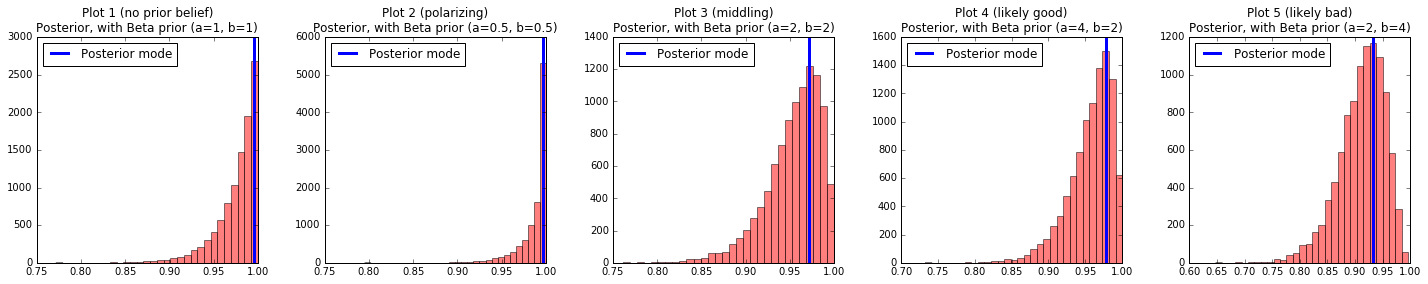

In [15]:
title = 'Shawshank Redemption'
plot_movie_posterior_from_title(title)

Analysis, The Shawshank Redemption:
- 1 (no prior belief) evidence says everyone is going to love it, so that remains unchanged
- 2 (polarizing) says the polarizing effect will be entirely positive, i.e. very likely everyone will like the movie. The prior essentially has no effect since the evidence was very positive to begin with (39 of 39 likes)
- 3 (middling), draws the predicted likability down a bit, moderating the very positive ratings
- 4 (likely good), prior belief has a moderating effect - evidence is overwhelmingly positive but the beta only said people would likely like the movie, not that everyone would love it. So prior reduces expected likability a bit.
- 5 (likely bad), even though the prior belief was that few people would like the movie, evidence is so overwhelmingly and convincingly positive that the needle will moved over to essentially 'likely good'

Down Periscope (1996): 0.0666666666667 (1.0/15.0)


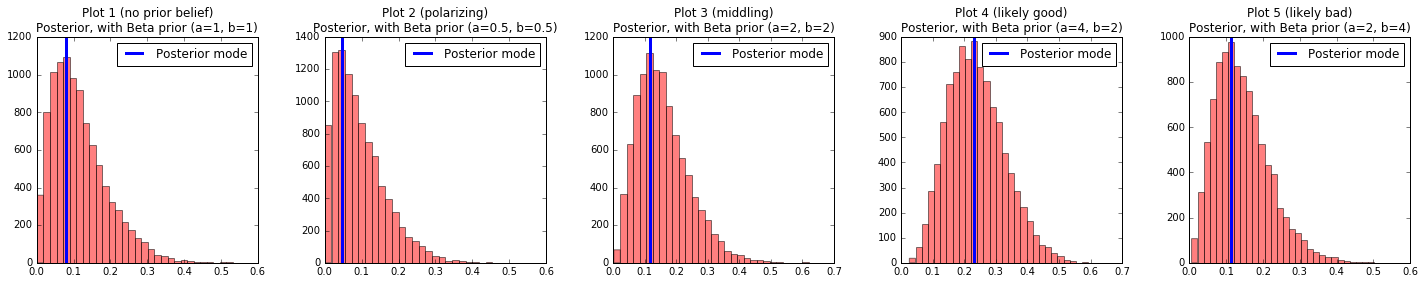

In [16]:
title = 'Down Periscope'
plot_movie_posterior_from_title(title)

Analysis, Down Periscope:
- the 'polarizing' beta distribution shows an even stronger negative likability than without any prior
- the remaining priors, beyond 'no prior belief' all have a moderating effect, improving the movies expected likability
  - the initial ratings are so poor, that even the 'likely bad' prior increases its expected likability, as that prior's mode was still to the right (to more positive likability) of this movies pure evidence based ratings

Chain Reaction (1996): 0.0 (0.0/10.0)


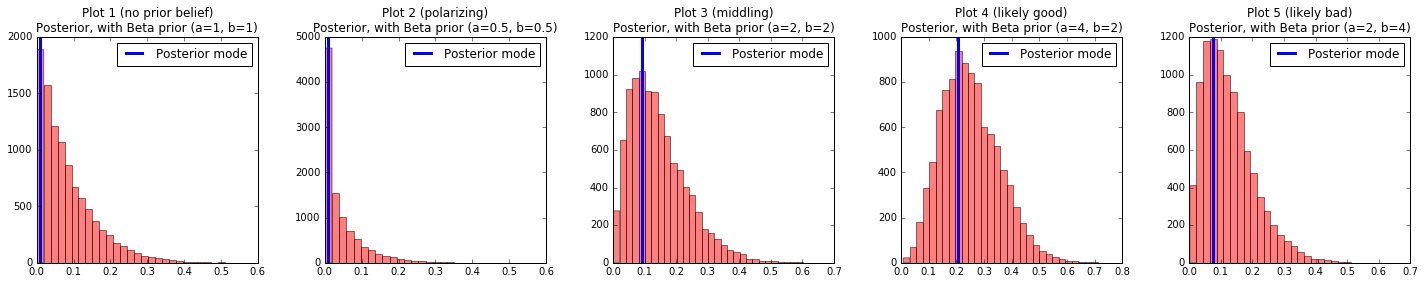

In [17]:
title = 'Chain Reaction'
plot_movie_posterior_from_title(title)

Analysis, Chain Reaction:
- similar effects to 'Down Periscope' but even more so
- most notably may be the 'polarizing' prior, where the extreme of dislikes are even more extreme
- and again, the 'likely bad' prior increases film's likability prediction, simply becuase 'likely bad' distribution is more positive than something like 'absolutely horrid' distribution

#### Task: 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.


number of subsamples: 100
Star Wars (1977): 0.865671641791 (58.0/67.0)


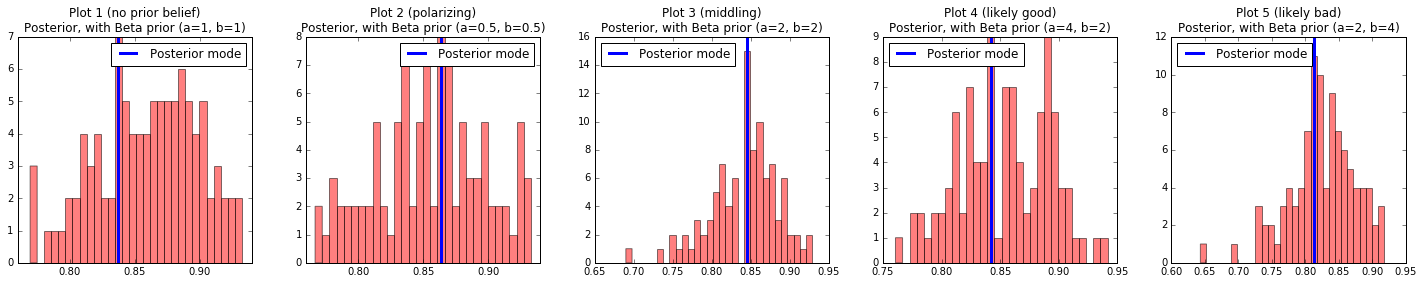

In [18]:
title = 'Star Wars'
n_samples = 100
print 'number of subsamples:', n_samples
plot_movie_posterior_from_title(title, n_samples)

number of subsamples: 10000
Star Wars (1977): 0.865671641791 (58.0/67.0)


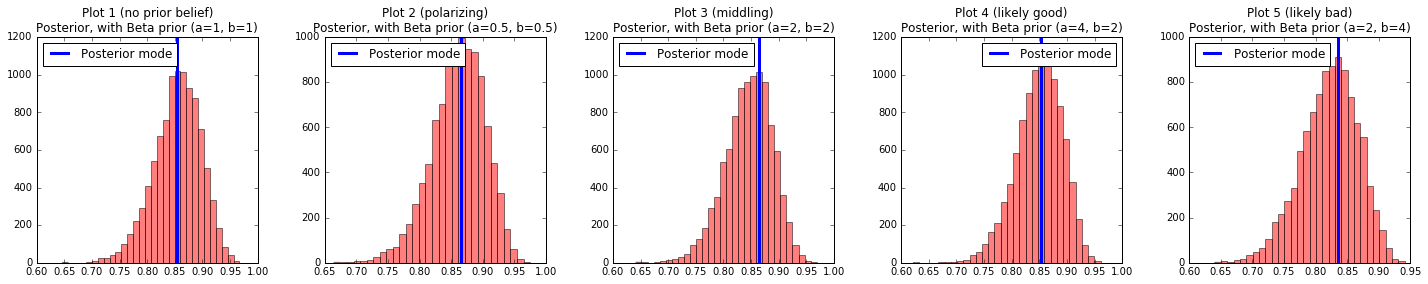

In [19]:
# orig n_samples = 10,000
n_samples=10000
print 'number of subsamples:', n_samples
plot_movie_posterior_from_title(title, n_samples)

number of subsamples: 500000
Star Wars (1977): 0.865671641791 (58.0/67.0)


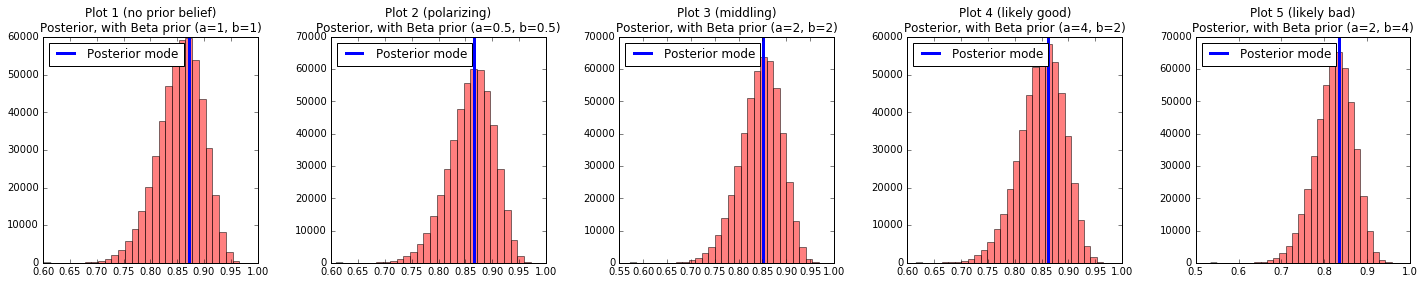

In [20]:
n_samples=500000
print 'number of subsamples:', n_samples
plot_movie_posterior_from_title(title, n_samples)

#### Task: Analysis: How does the effect of the prior on the posterior distribution vary with the number of user ratings?  
Overall, the general idea is that as the number of subsamples increases, the prior's effect on the posterior distribution increases. This is most noticeable in the likely good/likely bad plots, where we see the needle shifted in the direction of the prior in each case. With only 100 subsamples, the evidence (58 of 67 likes) predominates and there is little difference between 'no prior belief' and 'likely good/bad'. But as we hit 500,000 subsamples, the posterior becomes slightly more positive/likable for 'likely good' and slightly more negative/less-likable for 'likely bad' prior.


### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

In [21]:
#Choose a beta prior that encodes a reasonable belief about likability 
# below is 'middling', somewhat approximating a normal distribution centered around 50/50 likability prediction
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies_new = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
title_padding = max(len(movie[0]) for movie in top_25_movies_new) + 5
for movie, likes, total_ratings, likable in top_25_movies_new:
#    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)
    print '{0:<{1}} {2:<12.6} ({3}/{4})'.format(movie, title_padding, likable, likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994)                                                 0.973088     (39.0/39.0)
Godfather: Part II, The (1974)                                                   0.954935     (18.0/18.0)
Glory (1989)                                                                     0.954196     (17.0/17.0)
Manchurian Candidate, The (1962)                                                 0.95373      (17.0/17.0)
Cool Hand Luke (1967)                                                            0.953336     (20.0/20.0)
Raiders of the Lost Ark (1981)                                                   0.941004     (47.0/49.0)
Wrong Trousers, The (1993)                                                       0.932668     (14.0/14.0)
Killing Fields, The (1984)                                                       0.930115     (14.0/14.0)
Three Colors: Red (1994)                                                         0.923297     (12.0/12.0)
Hig

#### Task: Analysis: How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?
With the data frames displayed later on we can see all of the top 25 movies from the original list that had less than 10 ratings, except for one, are no longer present in new top 25.  
This new model is better, since the movies that were highly rated but only had a few reviews are no longer present.  
  
The new list still has problems though, as the movie "Timecop" does not appear in top 25. Nor do any other movies starring Jean-Claude Van Damme. Perhaps we need to institute a prior that any movie with JCVD is likely to be liked, not sure which beta distribution that is.


In [22]:
# pull out only movie & ranking count from orig list, + index as the rank
orig_data = [(i+1, movie[0], movie[2]) for i, movie in enumerate(top_25_movies)]
df_top_25_orig = pd.DataFrame(orig_data, columns=['rank','movie','count'])

# same for new top 25
new_data = [(i+1, movie[0], movie[2]) for i, movie in enumerate(top_25_movies_new)]
df_top_25_new = pd.DataFrame(new_data, columns=['rank','movie','count'])

# merge them via outer join so we don't lose any movies
df_top_25_both = pd.merge(df_top_25_new, df_top_25_orig, how='outer'
                          , left_on='movie', right_on='movie', suffixes=['_new', '_orig'])
# re-order the columns into something more display-friendly
df_top_25_both = df_top_25_both[['movie','rank_new','count_new','rank_orig','count_orig']]

In [23]:
print 'top 10 with the new rankings, rank_orig indicates rank in first model, NaN means the movie wasn''t in orig top 25'
df_top_25_both[df_top_25_both['rank_new'] > 0].head(10)

top 10 with the new rankings, rank_orig indicates rank in first model, NaN means the movie wasnt in orig top 25


,movie,rank_new,count_new,rank_orig,count_orig
0,"Shawshank Redemption, The (1994)",1,39,5,39
1,"Godfather: Part II, The (1974)",2,18,14,18
2,Glory (1989),3,17,NaN,NaN
3,"Manchurian Candidate, The (1962)",4,17,NaN,NaN
4,Cool Hand Luke (1967),5,20,NaN,NaN
5,Raiders of the Lost Ark (1981),6,49,NaN,NaN
6,"Wrong Trousers, The (1993)",7,14,13,14
7,"Killing Fields, The (1984)",8,14,NaN,NaN
8,Three Colors: Red (1994),9,12,3,12
9,High Noon (1952),10,11,NaN,NaN


In [24]:
print 'top 10 with the orig rankings, rank_new indicates rank in newer model, NaN means the movie isn''t in newer top 25'
df_top_25_both[df_top_25_both['rank_orig'] > 0].sort('rank_orig').head(10)

top 10 with the orig rankings, rank_new indicates rank in newer model, NaN means the movie isnt in newer top 25


,movie,rank_new,count_new,rank_orig,count_orig
25,French Twist (Gazon maudit) (1995),NaN,NaN,1,2
26,Exotica (1994),NaN,NaN,2,2
8,Three Colors: Red (1994),9,12,3,12
14,Three Colors: White (1994),15,8,4,8
0,"Shawshank Redemption, The (1994)",1,39,5,39
27,Brother Minister: The Assassination of Malcolm...,NaN,NaN,6,1
28,Carlito's Way (1993),NaN,NaN,7,4
29,Robert A. Heinlein's The Puppet Masters (1994),NaN,NaN,8,2
30,"Horseman on the Roof, The (Hussard sur le toit...",NaN,NaN,9,2
31,Wallace & Gromit: The Best of Aardman Animatio...,NaN,NaN,10,6


In [25]:
print 'of those in original top 25, the only one with fewer than 10 ratings still present in newer top 25'
print '  is "Three Colors: White (1994)"'
df_top_25_both[(df_top_25_both['rank_orig'] > 0) & (df_top_25_both['count_orig'] < 10)].sort('rank_orig')

of those in original top 25, the only one with fewer than 10 ratings still present in newer top 25
  is "Three Colors: White (1994)"


,movie,rank_new,count_new,rank_orig,count_orig
25,French Twist (Gazon maudit) (1995),NaN,NaN,1,2
26,Exotica (1994),NaN,NaN,2,2
14,Three Colors: White (1994),15,8,4,8
27,Brother Minister: The Assassination of Malcolm...,NaN,NaN,6,1
28,Carlito's Way (1993),NaN,NaN,7,4
29,Robert A. Heinlein's The Puppet Masters (1994),NaN,NaN,8,2
30,"Horseman on the Roof, The (Hussard sur le toit...",NaN,NaN,9,2
31,Wallace & Gromit: The Best of Aardman Animatio...,NaN,NaN,10,6
32,Maya Lin: A Strong Clear Vision (1994),NaN,NaN,11,1
33,Unhook the Stars (1996),NaN,NaN,12,1


#### Task: Analysis: So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users.
What can be the draw back of this method? How can we improve the recommender system for individual users 
(if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)?


Of course individual tastes vary greatly and something as simple as genre information could act as simple classifier, e.g. a prior that is more of a 'romantic comedies are likely good' could go into one set of predictions and 'romantic comdedies are likely not good' into another. Then a given person could lean toward the results of either model depending on their more personal preference.  
More complicated approaches involve something like Netflix uses, where if a given user likes A, B, C, & D and you like A, B, & C, there is a greater than average (across all movie watchers) chance that you will like movie D.

---

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. ~~The city of Boston estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.~~
we mean to say that:
"There is an approximate 25% increase among higher income group, and equal number of people decrease from the other groups (meaning total population in the entire area stays roughly the same through out time - this is a fairly reasonable assumption if there is no new real-estate development in this area and the so the number of houses must be fairly constant through time)."


Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

In [26]:
# modification or two to below

#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data, add in a line for y=2, high-income
    ax.scatter(x[y == 2, 0], x[y == 2, 1], c='y')
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='b')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='r')
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    #orig: n = size(interval)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # print 'xx.shape', xx.shape # (10000L, 2L) 
    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        print 'xx.shape', xx.shape # (10000L, 6L)
        # try summing next...
        
    # if poly_flag=True error: operands could not be broadcast together with shapes (10000,6) (2,)
    yy = model.predict(xx)
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax


#fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#poly_flag = False
#plot_decision_boundary(x=X.values, y=Y.values, model=model_lda, poly_flag=poly_flag, title='some title', ax=ax)

General theme with Question 2 is that I started with part a), did some work and ran into problems with poly_flag in above function and spent too much time trying to figure it out. I then jumped to b), did a bunch of work and then from there switched to Project work (I didn' find homework 5 & 6 to be any shorter than the ones that came before).

In [28]:
# use 2000 for data exploration

df_2000 = pd.read_csv('datasets/dataset_1_year_2000.txt', delimiter=' ', header=None, names=['lat','lon','status'])
df_2000.head()

,lat,lon,status
0,0.544328,0.624510,2
1,0.594685,0.723913,2
2,0.700180,0.782492,2
3,0.601262,0.971812,2
4,0.631995,0.748502,2


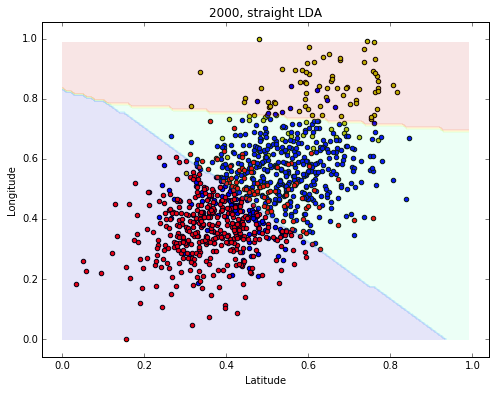

In [29]:
# PLot the 2000 data w/decision boundaries using LDA

# lec14 uses: LDA = da.LinearDiscriminantAnalysis()
lda = LDA()
X = df_2000[['lat','lon']]
Y = df_2000['status']
model_lda = lda.fit(X, Y)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax (a set of axes to plot on)
poly_flag = False
title = '2000, straight LDA'
out = plot_decision_boundary(x=X.values, y=Y.values, model=model_lda, poly_flag=poly_flag, title=title, ax=ax)


Logistic Regression, to my eye slightly less accurate boundaries vs. LDA.


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


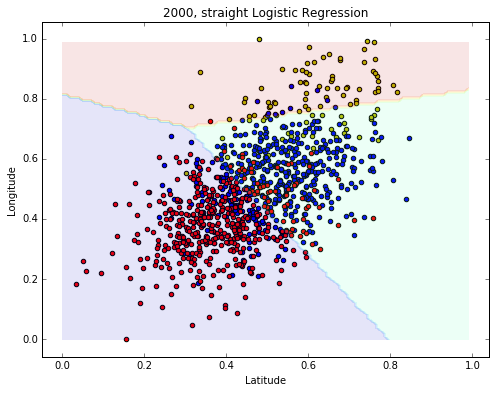

In [30]:
# simple Logistic Regression decision boundaries for 2000
print
print 'Logistic Regression, to my eye slightly less accurate boundaries vs. LDA.'

logit = linear_model.LogisticRegression(C = 1000000)
model_logit = logit.fit(X,Y)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.legend(loc='best')

poly_flag = False
title = '2000, straight Logistic Regression'
out = plot_decision_boundary(x=X.values, y=Y.values, model=model_logit, poly_flag=poly_flag, title=title, ax=ax)

In [31]:
print 'based on all data from 2000:'
print '- overall misclassification rate of LDA is {}'.format(1-model_lda.score(X,Y))
print '- overall misclassification rate of Log Reg is {}'.format(1-model_logit.score(X,Y))


based on all data from 2000:
- overall misclassification rate of LDA is 0.208
- overall misclassification rate of Log Reg is 0.219


In [32]:
# put all the years into a single data frame, and then a separate one holding the status proportions over the years
df = pd.DataFrame(columns=['lat','lon','status','year'])
df_pct = pd.DataFrame(columns=['year', 'status', 'status_pct'])
for year in xrange(2000,2011):
    df_year = pd.read_csv('datasets/dataset_1_year_{}.txt'.format(year), delimiter=' ', 
                          header=None, names=['lat','lon','status'])
    df_year['year'] = year
    df = df.append(df_year, ignore_index=True)
    
    df_group = df_year.groupby('status').size().reset_index() 
    df_pct_year = pd.DataFrame(df_group['status'])
    df_pct_year['status_pct'] = df_group[0]/(1.0 * len(df_year))
    df_pct_year['year'] = year
    df_pct = df_pct.append(df_pct_year)


df_pct.head(6)

,status,status_pct,year
0,0,0.450000,2000
1,1,0.450000,2000
2,2,0.100000,2000
0,0,0.437562,2001
1,1,0.437562,2001
2,2,0.124875,2001


### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1 - high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

In [33]:
# peek at first dataset
df_1 = pd.read_csv('datasets/dataset_2.txt', delimiter=' ', header=None, names=['lat','lon','status'])
print 'shape: ', df_1.shape
print 
print 'count per status value:'
print df_1.groupby('status').size()
df_1.head()

shape:  (2000, 3)

count per status value:
status
0         1000
1         1000
dtype: int64


,lat,lon,status
0,0.542866,0.433326,1
1,0.512297,0.491020,1
2,0.620624,0.303222,1
3,0.620553,0.478634,1
4,0.437379,0.418034,1


In [34]:
# and now the second
df_2 = pd.read_csv('datasets/dataset_3.txt', delimiter=' ', header=None, names=['lat','lon','status'])
print 'shape: ', df_2.shape
print 
print 'count per status value:'
print df_2.groupby('status').size()
df_2.head()

shape:  (2000, 3)

count per status value:
status
0         1000
1         1000
dtype: int64


,lat,lon,status
0,0.126227,0.846415,1
1,0.115902,0.886631,1
2,0.139295,0.794580,1
3,0.123552,0.832449,1
4,0.163855,0.824699,1


In [35]:
# simple function for a scatter plot visualization

def plot_dataset(x, y, title, ax):
        
    ax.scatter(x[y==0, 0], x[y==0, 1], color='r', label='0', marker='$0$')
    ax.scatter(x[y==1, 0], x[y==1, 1], color='b', label='1', marker='$1$')

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title(title)
    ax.legend()
    
    return ax


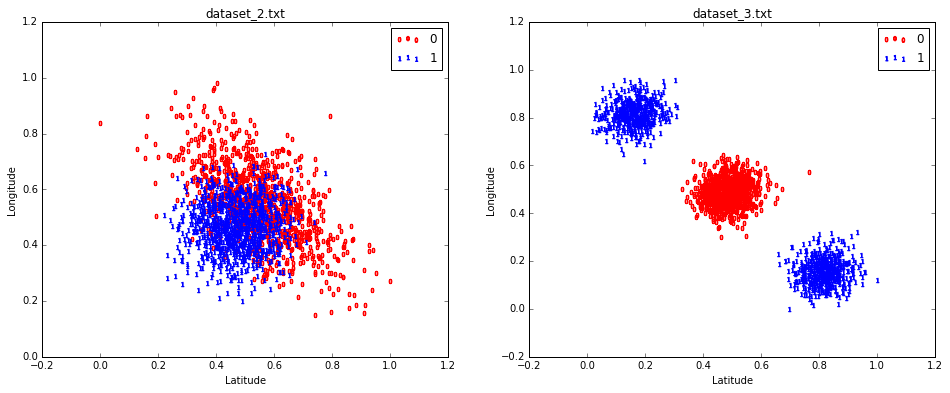

In [36]:
# plot both to get a feel for status distribution across Lat/Lon

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x_2 = df_1[['lat','lon']]
y_2 = df_1['status']
plot_dataset(x_2.values, y_2.values, title='dataset_2.txt', ax=ax1)

x_3 = df_2[['lat','lon']]
y_3 = df_2['status']
plot_dataset(x_3.values, y_3.values, title='dataset_3.txt', ax=ax2)


plt.show()

Reviewing dataset_2.txt
- both distributions appear to be multivariate normal
- covariances are not the same, so the boundary will be curved (which also appears to be the case by eye)
- since there is so much overlap, KNN probably won't do well
- in terms of remaining options that would potentially produce a curved decision boundary
    - logistic regression with quadratic effect
    - QDA  
    
  are both viable options. There aren't a large number of classes vs. observations, which might put us away from QDA. Might as well run a test or two.


take a look at a proposed decsion boundary using all data, QDA looks reasonable


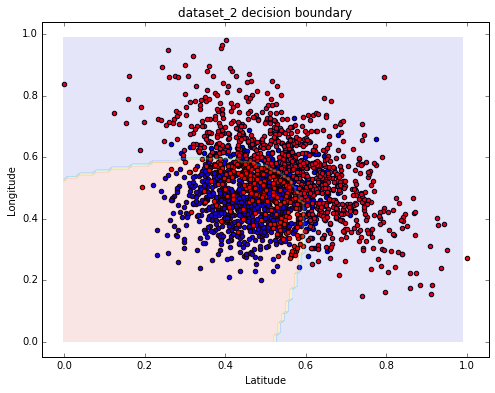

In [37]:
print
print 'take a look at a proposed decsion boundary using all data, QDA looks reasonable'

qda = QDA()
model_qda_2 = qda.fit(x_2, y_2)
poly_flag = False
title = 'dataset_2 decision boundary'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_decision_boundary(x=x_2.values, y=y_2.values, model=model_qda_2, poly_flag=poly_flag, title=title, ax=ax)
plt.show()

In [38]:
# create models based off of training sets & return dictionary of all
# - LDA, QDA, Logistic Regression, Logistic Regression with quadratic effects, knn-k=3, knn-k=25
def gen_class_models(x_train, y_train):
    models = collections.OrderedDict()
    lda = LDA()
    models['lda'] = lda.fit(x_train, y_train)

    qda = QDA()
    models['qda'] = qda.fit(x_train, y_train)
    
    logit1 = linear_model.LogisticRegression(C = 1000000)
    models['logit1'] = logit1.fit(x_train, y_train)

    logit2 = linear_model.LogisticRegression(C = 1000000)
    # additional square terms for each predictor
    x_train_quad = np.concatenate([x_train, x_train**2], axis=1)
    models['logit2'] = logit2.fit(x_train_quad, y_train)

    knn3=knn.KNeighborsClassifier(3)
    models['knn3'] = knn3.fit(x_train,y_train)

    knn25=knn.KNeighborsClassifier(25)
    models['knn25'] = knn25.fit(x_train,y_train)
    
    return models
        

In [39]:
# create train & test, better case scenario would have involved cross-validation, but will need to be
#   satisfied with what I got
np.random.seed(109)
x_train, x_test, y_train, y_test = sk_split(x_2, y_2, test_size=0.30)

columns=['model_type', 'Misclassification Rate']
df_model_stats = pd.DataFrame(columns=columns)
models = gen_class_models(x_train, y_train)
for key, model in models.iteritems():
    if key != 'logit2':
        misclass_rate = 1-model.score(x_test, y_test)
    else:
        x_test_quad = np.concatenate([x_test, x_test**2], axis=1)
        misclass_rate = 1-model.score(x_test_quad, y_test)
    row = pd.DataFrame([[key, misclass_rate]], columns=columns)
    row = pd.DataFrame([[key, misclass_rate]], columns=columns)
    df_model_stats = df_model_stats.append(row)

print 'dataset_2 results'
df_model_stats

dataset_2 results


,model_type,Misclassification Rate
0,lda,0.258333
0,qda,0.231667
0,logit1,0.258333
0,logit2,0.223333
0,knn3,0.243333
0,knn25,0.238333


Logical regression with quadratic effects has the lowest misclassification rate on test set and its performance should be good. That being said, QDA next lowest score and will usually run even more quickly - if the dataset were significantly larger, QDA might get the edge instead. Of course the right answer would also involve cross validation - my investigation was on a single train/test set.  
Next I run through decision boundaries on the various models to make sure things look as expected.

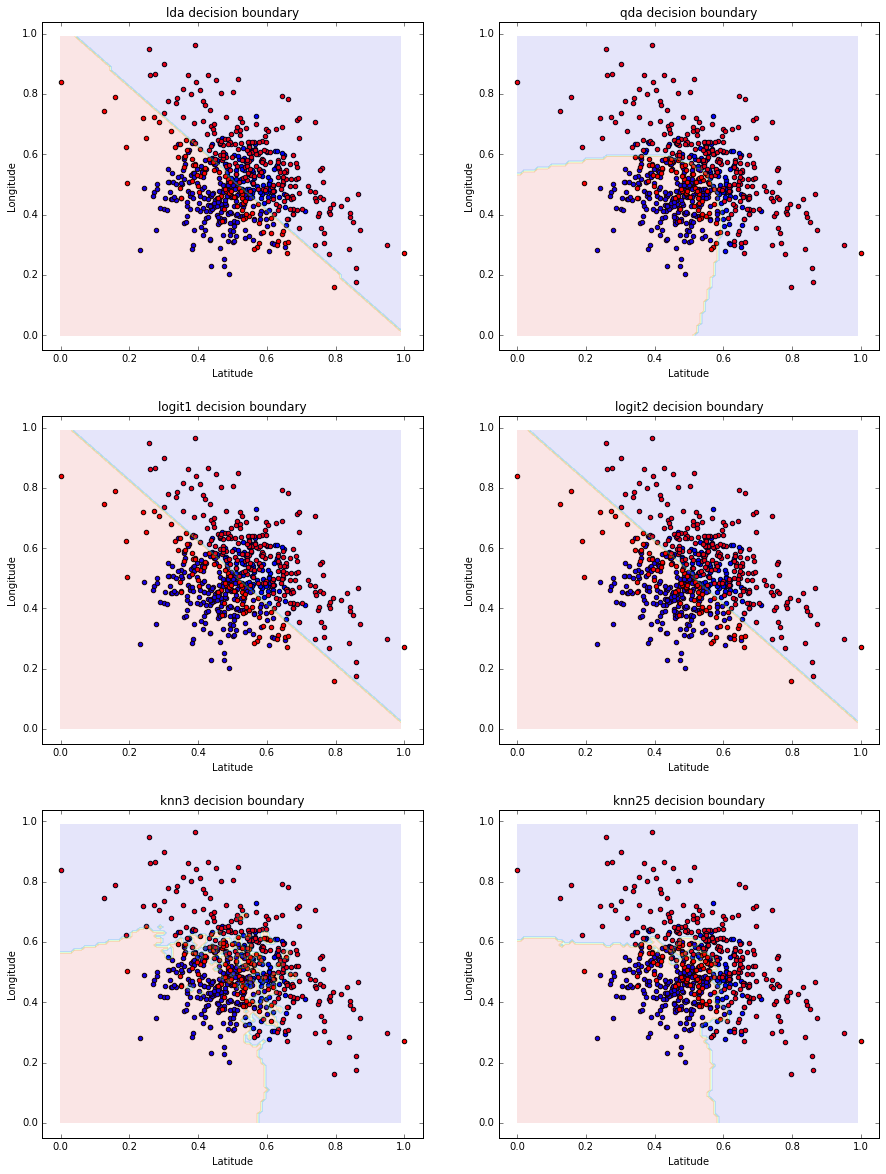

In [40]:
# visualize decision boundaries for each model as sanity check
fig, ax = plt.subplots(3, 2, figsize=(15, 20))

row = 0
poly_flag = False
for idx, (key, model) in enumerate(models.iteritems()):
    title = '{} decision boundary'.format(key)
    
    if key != 'logit2':
        plot_decision_boundary(x=x_test, y=y_test, model=model, poly_flag=poly_flag, title=title, ax=ax[row][idx%2])
    else:
        #placeholder until I can figure out poly_flad issue in plot_decision_boundary(), or time runs out (time ran out)
        model=models['logit1'] 
        plot_decision_boundary(x=x_test, y=y_test, model=model, poly_flag=poly_flag, title=title, ax=ax[row][idx%2])
        #x_test_quad = np.concatenate([x_test, x_test**2], axis=1)
        #plot_decision_boundary(x=x_test_quad, y=y_test, model=model, poly_flag=poly_flag, title=title, ax=ax[row][idx%2])
        
    if idx%2 != 0:
        row += 1 

plt.show()

Dataset_3.txt does not appear to be Multivariate Normal at all, with two distinct clusters of 1/high-income. KNN, preferably with a low k so as to prevent neighbors reaching across the clusters seems like it would be a good approach.

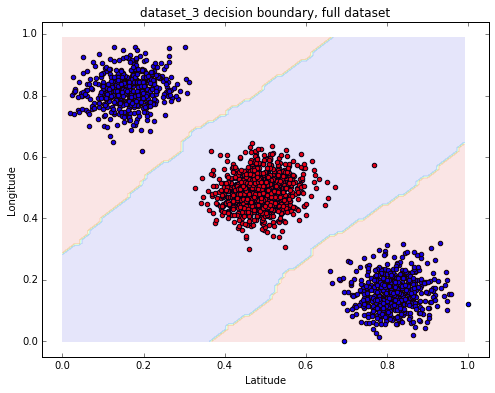

In [41]:
knn3=knn.KNeighborsClassifier(3)
knn3_model_3 = knn3.fit(x_3, y_3)

poly_flag = False
title = 'dataset_3 decision boundary, full dataset'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_decision_boundary(x=x_3.values, y=y_3.values, model=knn3_model_3, poly_flag=poly_flag, title=title, ax=ax)
plt.show()

Clear decision boundary but it makes sense to run through all of the models, especially since knn can be not so quick to run. Presumbly there isn't a straight line that will do a good job though.

In [42]:
np.random.seed(109)
x_train, x_test, y_train, y_test = sk_split(x_3, y_3, test_size=0.30)

columns=['model_type', 'Misclassification Rate']
df_model_stats = pd.DataFrame(columns=columns)
models = gen_class_models(x_train, y_train)
for key, model in models.iteritems():
    if key != 'logit2':
        misclass_rate = 1-model.score(x_test, y_test)
    else:
        x_test_quad = np.concatenate([x_test, x_test**2], axis=1)
        misclass_rate = 1-model.score(x_test_quad, y_test)
    row = pd.DataFrame([[key, misclass_rate]], columns=columns)
    row = pd.DataFrame([[key, misclass_rate]], columns=columns)
    df_model_stats = df_model_stats.append(row)

print 'dataset_3 results'
df_model_stats
# ['lda', 'qda', 'logit1', 'logit2', 'knn3', 'knn25']

dataset_3 results


,model_type,Misclassification Rate
0,lda,0.603333
0,qda,0.021667
0,logit1,0.603333
0,logit2,0.000000
0,knn3,0.000000
0,knn25,0.000000


As expected, knn approaches were quite good and given the overal spread of the data, it isn't surprising everything was classified correctly, no reason to believe overfitting is taking place. Of course the Logistic Regression with quadratic effects was just as good an is likely to run significantly quicker than KNN, so this likely the winner. Following that would be knn3 then knn25 since the former should be more performant than the latter.  
Same as before, cross validation or at least multiple train/test splits are in order, though the above results, combined with the initial data plot, make above analysis pretty convincing.

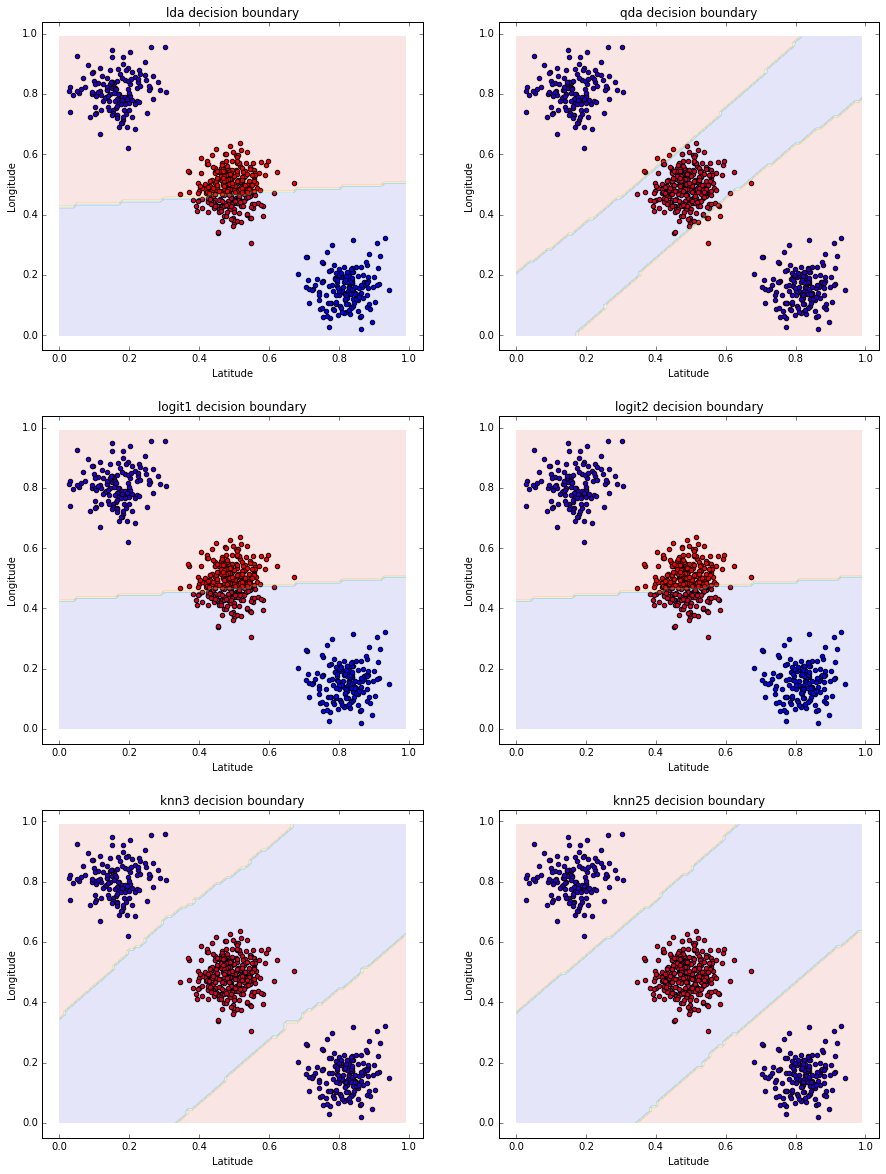

In [43]:
# visualize decision boundaries for each model as sanity check
fig, ax = plt.subplots(3, 2, figsize=(15, 20))

row = 0
poly_flag = False
for idx, (key, model) in enumerate(models.iteritems()):
    title = '{} decision boundary'.format(key)
    
    if key != 'logit2':
        plot_decision_boundary(x=x_test, y=y_test, model=model, poly_flag=poly_flag, title=title, ax=ax[row][idx%2])
    else:
        model=models['logit1'] #placeholder until I can fix
        plot_decision_boundary(x=x_test, y=y_test, model=model, poly_flag=poly_flag, title=title, ax=ax[row][idx%2])
        #x_test_quad = np.concatenate([x_test, x_test**2], axis=1)
        #plot_decision_boundary(x=x_test_quad, y=y_test, model=model, poly_flag=poly_flag, title=title, ax=ax[row][idx%2])
        
    if idx%2 != 0:
        row += 1 

plt.show()

---

## Challenge Problem: Regularization

We have seen ways to include different forms of regularizations in Linear regression and Logistic regression, in order to avoid overfitting. We will now explore ways to incorporate regularization within the discriminant analysis framework.

- When we have a small training sample, we end up with poor estimates of the class proportions $\pi_i$ and covariance matrices $\Sigma$. How can we regularize these quantities to improve the quality of the fitted model?


- We have seen that different assumptions on the covariance matrix results in either a linear or quadratic decision boundary. While the former may yield poor prediction accuracy, the latter could lead to over-fitting. Can you think of a suitable way to regularize the covariance to have an intermediate fit?

The solutions that you suggest must include a parameter that allows us to control the amount of regularization.

Be detailed in your explanation and support your reasoning fully. You do not, however, need to implement any of these solutions.